# Case study: Row-Column Addressed Matrix Probe

## Row-Column Addressed probes

A Row-Column Addressed (RCA) probe is a low-cost and portable alternative to fully-populated matrix-array probes in 3D volume reconstruction. 

In 3D ultrasound imaging, matrix-array probes are currently the most popular choice. They are a natural extension of linear-array probes. While in the latter the elements are distributed along a single axis (see images below), the matrix-array probes have $n \times n$ elements arranged on a plane along two axes (x and y).

One problem in handling matrix-array probes is a large number of ultrasound system channels that are needed to control all of the probe elements. In the case of the matrix array probe this is equal to $n^2$, so it increases quadratically with the number of elements along a single axis. For example, the currently popular $32 \times 32$ probe requires an ultrasound system with 1024 channels. Compare it to linear-array probes, which typically have 128-192 elements and require a system with the same number of channels. 

Various attempts have been made to implement 3D volume reconstruction using a system with a limited number of components. The RCA probes are gaining more and more popularity primarily due to the large number of elements (and therefore a larger aperture) that can be handled by a small number of system channels and ease of implementation of synthetic aperture methods. There are also some challenges and limitations, in particular [Jensen2022]:
- it is usually possible to image a rectangular area below the probe only,
- the long probe elements need to be considered at the beamforming stage (superposition of cylindrical waves), 
- some new artifacts such as edge waves must be considered in the imaging procedure, which means we may need to implement additional techniques like roll-off apodization.

In this notebook we present an implementation of plane wave imaging (PWI) with RCA probes. We focus on NVIDIA CUDA beamformer implementation details.

This notebook draws on work presented in [Flesch2017] and [Jensen2022].

### Coordinate system and units

In this notebook we assume the following coordinate system:
- the origin of the system $(0,0,0)$ is located at the center of the probe, 
- OX axis is along the probe's azimuth,
- OY is along the probe's elevation,
- OZ - depth (towards the direction of imaging).

See the image below for more details.

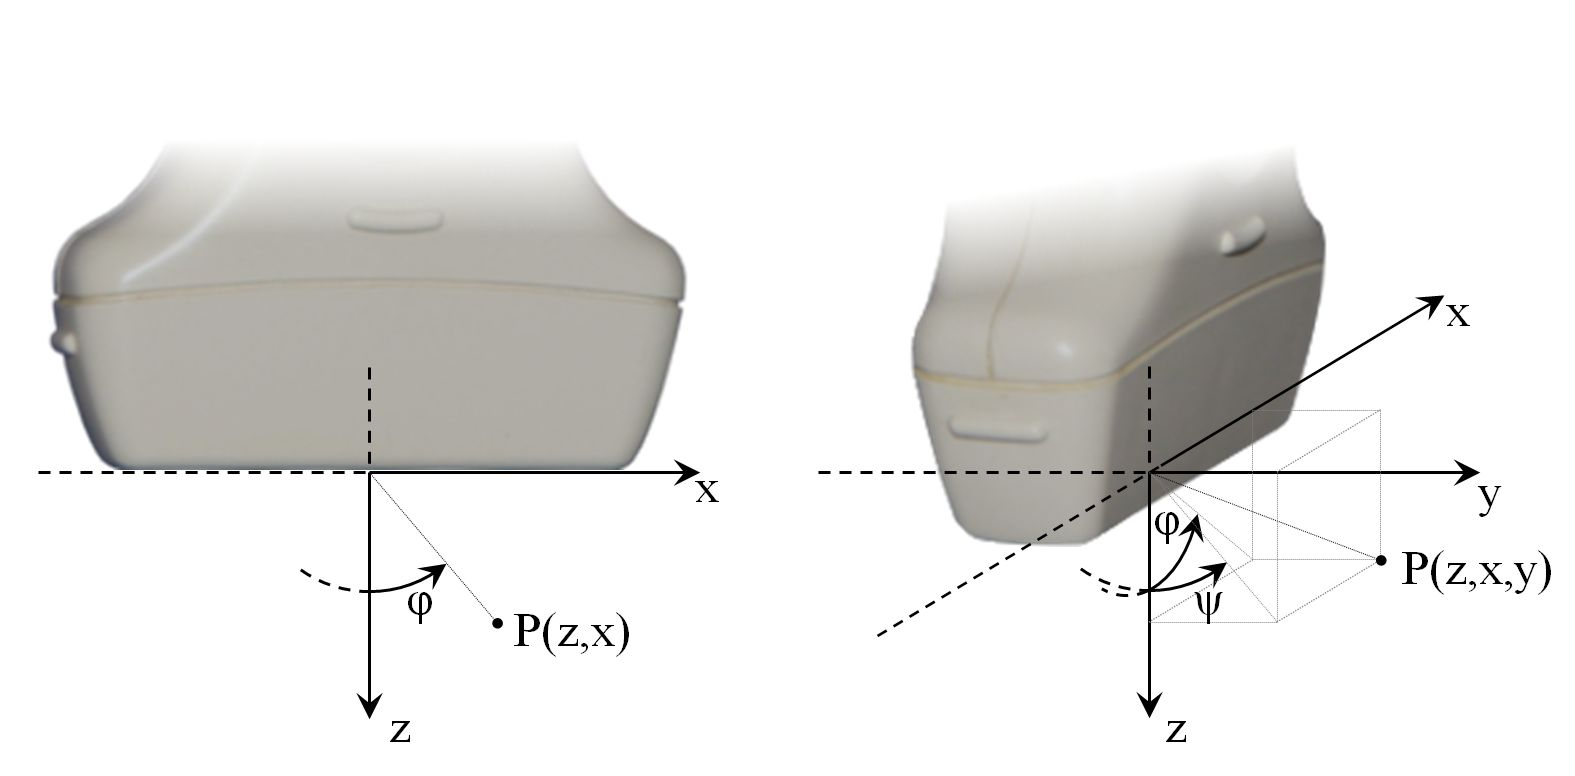

We use standard SI units, in particular: distance: meters (m), time: seconds (s), frequency: Hertz (Hz), and so on. In the GPU kernel implementation we avoid using SI unit prefixes such as mega-, kilo-, etc. 

### Rows and columns in RCA probes

The figure below shows the idea of the RCA probe construction:
1. _(the 1st image on the left)_: Here we consider a probe with $6 \times 6$ elements. These elements are evenly distributed along both of the axes. If we want to control all elements of the probe, we need a system with 36 channels.
2. _(the 2nd and 3rd images)_: Instead of controlling all the elements of the probe, in the case of an RCA probe we want to control groups of elements that are spread along the OX or OY axis. In other words, we would like to control 6 long elements along the OX axis and 6 long elements along the OY axis. This way, we are able to control the signal beamforming along the OX axis (e.g. on transmission) and the OY axis (e.g. on reception), which gives us a degree of freedom in 3D volume reconstruction. What is more, we only need $6+6$ channels to control the probe.

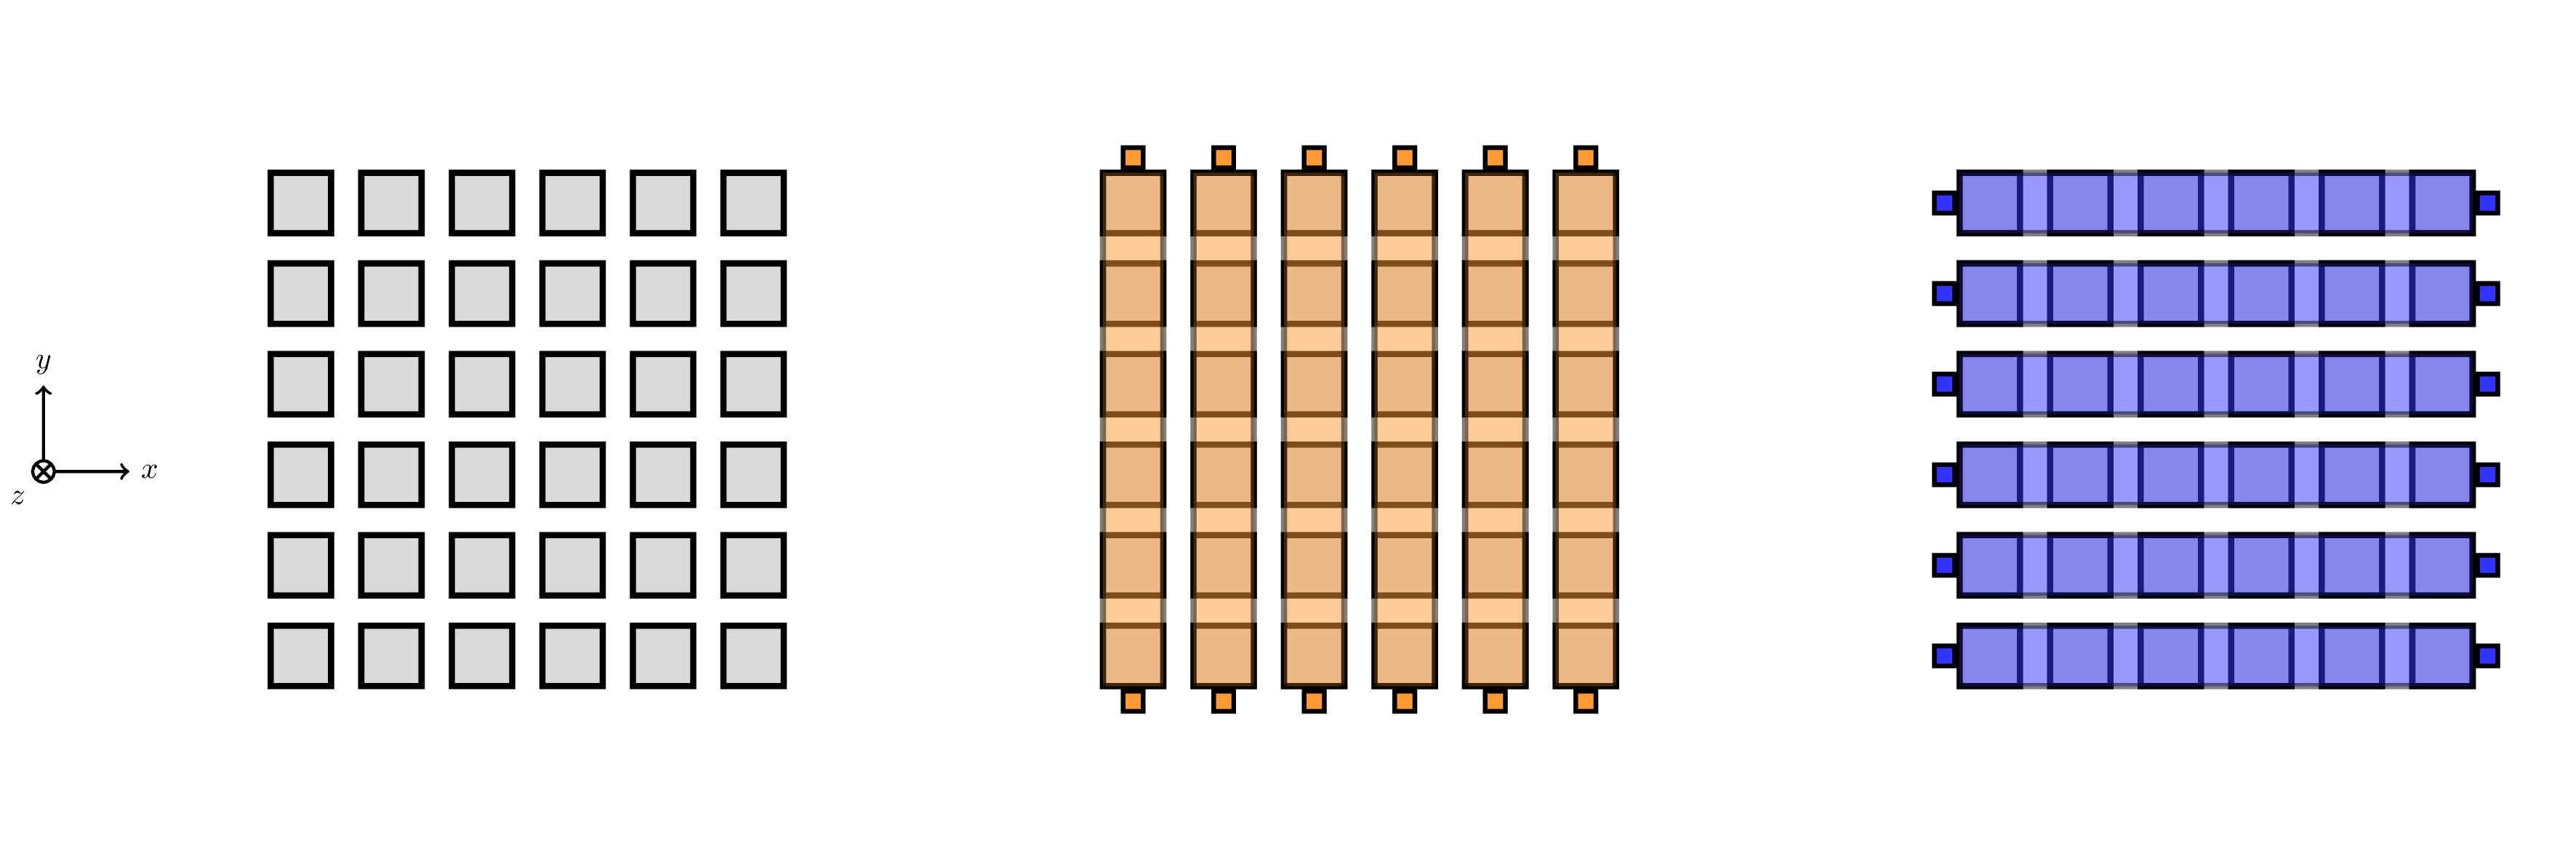

## Plane Wave Imaging with RCA

When imaging with the RCA probe, we must be able to control the elements distributed along the OX/OY axes and receive the signal with orthogonal elements (OY/OX). Otherwise, we will create a situation similar to a linear-array probe (but where the elements are much longer). The image below shows the idea: let's assume that we transmit signal using elements distributed along the OX axis (orange) and receive data using orthogonal elements (OY axis, blue).

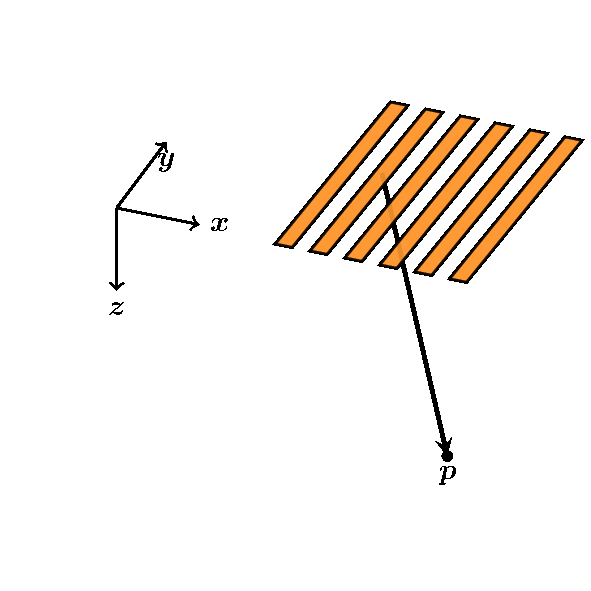

In case of plane wave transmission, the emitted wavefronts should have a rectangular shape, tilted along one of the axes according to the steering angle $\varphi$ (see image below, orange dotted lines). At the beamforming stage we need first to determine how much time it takes to propagate the signal from probe to the target point, then back to the receive channels. After determining the transmit and receive delays, we run the usual delay and sum algorithm in order to obtain information about the signal amplitude in each imaging grid point.

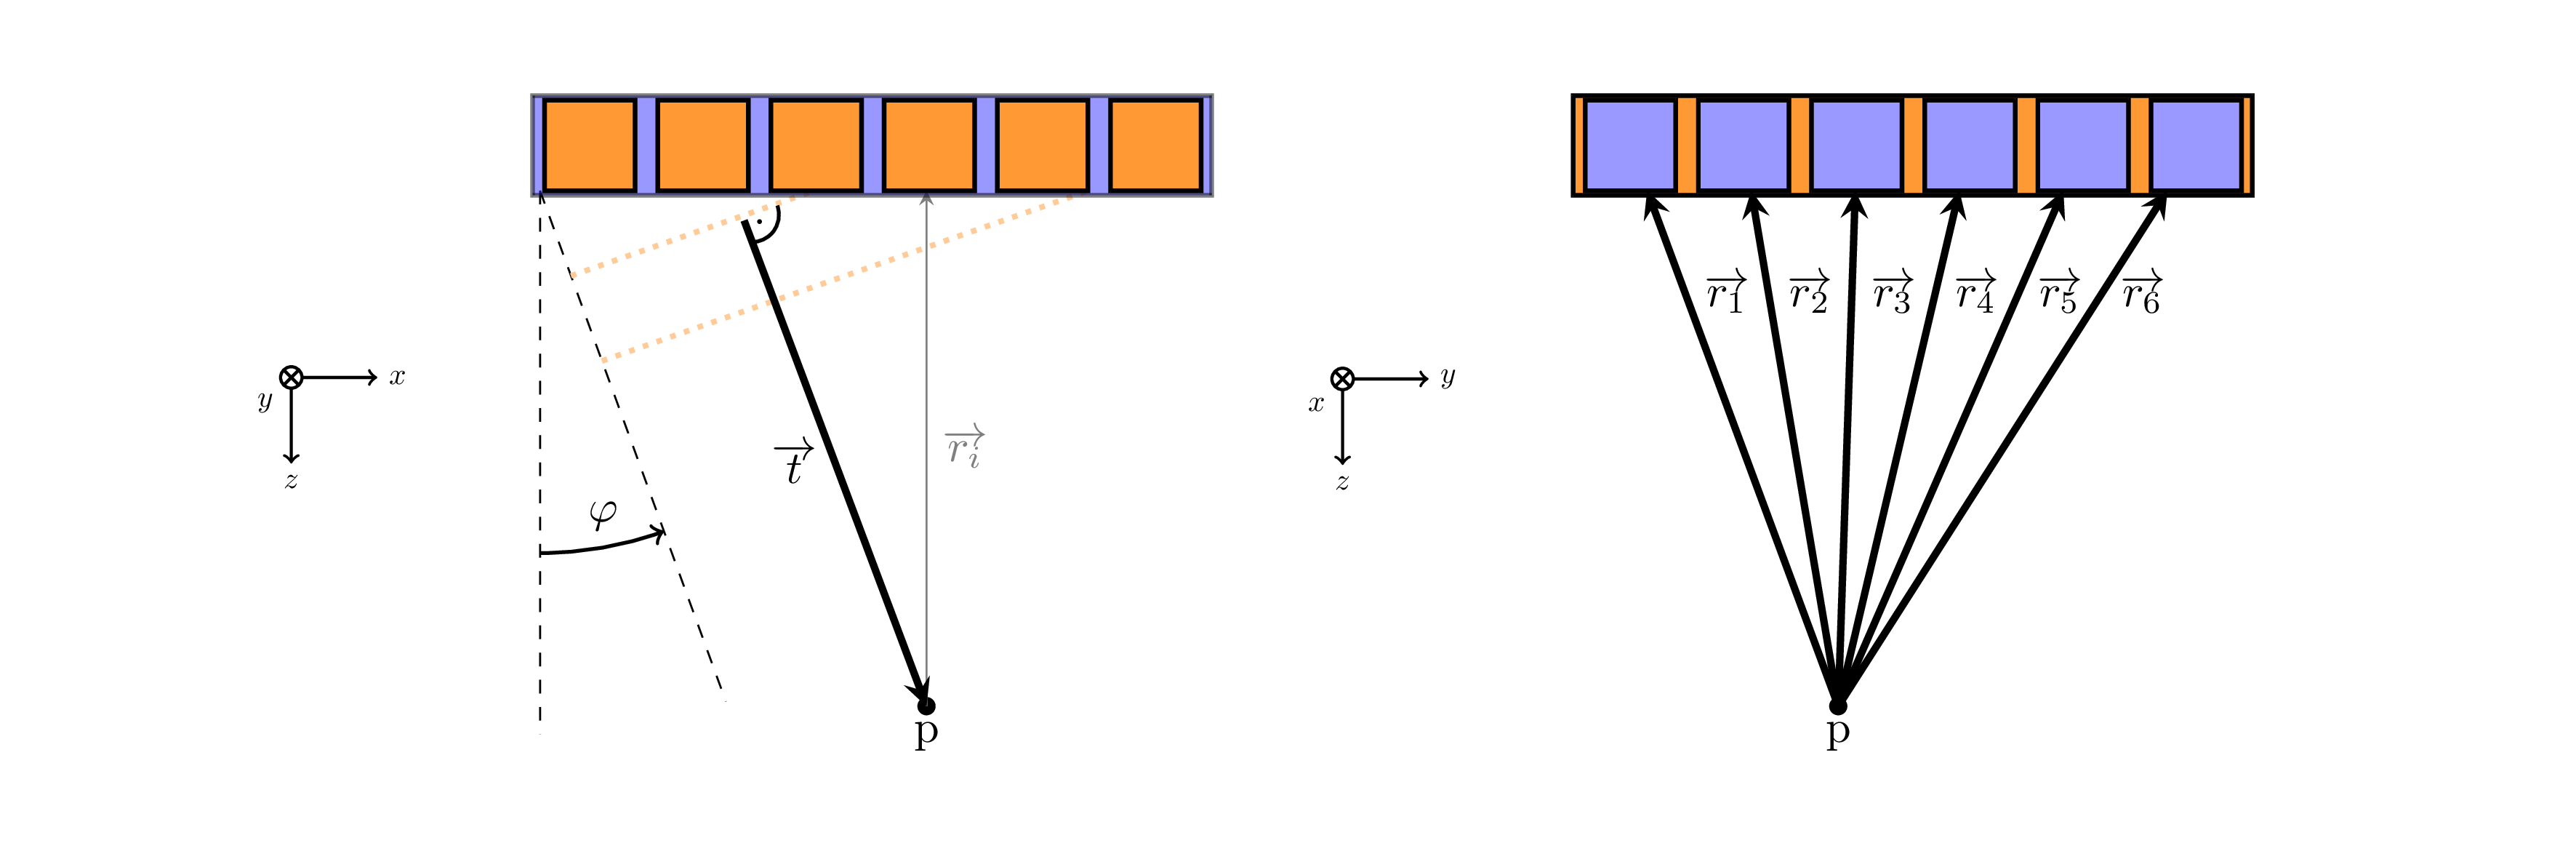

The transmit delay can be computed in the following way [Flesch2017]:

$\tau(x, y, z, \varphi, r_i) = \frac{\| \overrightarrow{t} \| + \|\overrightarrow{r_i}\|}{c}$

$\|\overrightarrow{t}\| = z\cos(\varphi) + x \sin(\varphi)$

$\|\overrightarrow{r_i}\| = \sqrt{z^2 + (y-r_i)^2}$ 

where:
- $\tau$: receive beamforming delay $(s)$,
- $p = (x, z, y)$ - a target point,
- $\overrightarrow{t}$ - a vector from the transimssion point to the target point $p$,
- $\overrightarrow{r_i}$ - a vector from the target point $p$ to the receive element $r_i$,
- $\varphi$ - steering angle $(rad)$,
- $c$ - speed of sound $(m/s)$. 

Based on the transmission and receive delays, we can make the following observations:
- with the RCA probe, we are only able to steer the transmit beam using angles $(\varphi, \psi=0)$ or $(\varphi=0, \psi)$, where $\psi$ is the receive angle;
- in the receive beamforming, $\|\overrightarrow{t}\|$ **does not depend on the** $y$ **value, and** $\|\overrightarrow{r_i}\|$ **does not depend on the** $x$ **value**. This means that we need to compute transmit delays for each $(x, z)$ pair only, and use it for all voxels along the OY axis. Thus, we are able to reduce calculation along one of the dimensions.

## Volume reconstruction

Let's start implementing the reconstruction algorithm. First, we will import all the necessary Python packages.

Note: 
- The `rca_utils` is a Python module implemented in the `rca_utils.py` file.
- We will use [Panel](https://panel.holoviz.org/) and [vtk](https://pypi.org/project/vtk/) packages for 3D volume visualization.

In [ ]:
import numpy as np
import scipy.io
import scipy.signal
import scipy.ndimage
import matplotlib.pyplot as plt
import cupy as cp
import h5py
import pathlib
import panel as pn
pn.extension('vtk')
from rca_utils import (
    view_medium_and_probe_3d,
    view_medium_and_probe_2d,
    view_volume_3d,
    view_volume_2d,
    pretty_print_h5_group,
)


### Data sets

In this notebook we will use synthetic data generated in the [k-Wave](http://www.k-wave.org/) simulator. The following environments have been simulated:
- a single point at 20 mm depth,
- a collection of threads at depths from 10 to 40 mm,
- a single cyst at 20 mm depth.

#### Get data

Let's download and load one of the available datasets (in [HDF5 format](https://www.hdfgroup.org/solutions/hdf5)).

In [ ]:
! wget -nc -nv https://www.dropbox.com/s/w9d26v7b332vt92/ball.h5 -P ./data
! wget -nc -nv https://www.dropbox.com/s/dpgct2x4wuce61t/cyst.h5 -P ./data
! wget -nc -nv https://www.dropbox.com/s/yqanmmr5n0yf3yf/multi_wire.h5 -P ./data

In [ ]:
f = h5py.File("data/cyst.h5", "r")
f.keys()

The file consists of several hdf5 groups (*fields*) containing raw channel data and their metadata, which we describe below. We use the `pretty_print_h5_group` function to present all the information available in the file.

#### Medium

In [ ]:
medium = f["medium"]
pretty_print_h5_group(medium)

The `medium` group describes the medium through which the ultrasonic signal was propagated. The following fields are available:
- `speed_of_sound`: assumed speed of sound in the medium (m/s),
- `dx`: a distance between two grid points in the density_array and speed_of_sound_array,
- `density_array`: a 3D map of density in the medium,
- `speed_of_sound_array`: a 3D map of speed of sound in the medium.

We use the `dx`, `density_array` and `speed_of_sound` parameters only to visualize the medium through which the ultrasound beam has been propagated.

#### Device

In [ ]:
device = f["device"]
pretty_print_h5_group(device)

The `device` group describes the device used to transmit and receive an ultrasonic beam, i.e. probe, ultrasound system (both simulated in k-Wave). The following fields are available:
- `n_elements_xy`: number of elements along the OX axis,
- `n_elements_yx`: number of elements along the OY axis,
- `pitch`: a distance between two probe elements,
- `probe_mask`: a binary mask of the insonified medium, where `1` means there was a transducer at the given location, 0 otherwise,
- `sampling_frequency`: data sampling frequency.

We use the `probe_mask` parameter only to visualize the transducer in the medium through which the ultrasound beam has been propagated.

Now, having information about the parameters of the device and the medium, we will present the sound velocity distribution in the medium at the time of transmitting the ultrasonic signal. The following code uses the tools from the `rca_utils`. 

In [ ]:
view_medium_and_probe_2d(medium, device, probe_c=1600, figsize=(10, 5))
plt.show()

If you want to see the presentation in 3D, uncomment the cell below.

In [ ]:
# Uncomment the below lines to get the 3D visualization.
# camera_state = {"position": [30.649595627318874, 559.0460803905869, -16.879074818048537], "focalPoint": [107.5, 107.5, 215.5], "viewUp": [0.057747151432525394, -0.44903855002421966, -0.8916443501158829], "viewAngle": 30, "parallelScale": 131.4562664919402, "clippingRange": [395.47055895500773, 634.5553852882013], "windowCenter": [0, 0], "screenBottomLeft": [-0.5, -0.5, -0.5], "screenBottomRight": [0.5, -0.5, -0.5], "screenTopRight": [0.5, 0.5, -0.5], "physicalTranslation": [-107.5, -107.5, -215.5], "physicalScale": 131.4562664919402, "physicalViewUp": [0, 1, 0], "physicalViewNorth": [0, 0, -1], "mtime": 53436, "distance": 513.6145264511501}
# view_medium_and_probe_3d(medium, device, probe_c=1600, edge_gradient=0.8, camera=camera_state)

#### TX/RX Sequence

In [ ]:
tx_rx_sequence = f["tx_rx_sequence"]
pretty_print_h5_group(tx_rx_sequence)

The `tx_rx_sequence` group describes the TX/RX sequence that was used during data acquisiion. The following fields are available:
- `angles`: a list of transmit angles $(rad)$,
- `init_delay`: moment of transmission at the center of the aperture (`time=0` is assigned to the first acquired sample) $(s)$,
- `transmit_frequency`: center frequency of the transmitted beam $(Hz)$.

Note: the transmit delays were chosen such that for all angles, the aperture center was always transmitting at the same time. In particular: for angle $0$, all transmit delays were set to the `init_delay` value; for angles other than $0$, the elements at the center aperture (e.g. elements 31 and 32 for 64-element aperture) were transmitting at `~ init_delay`. As we will see later, this approach will simplify the implementation of the receive beamformer.

#### Raw channel data

Finally, the dataset contains the raw channel data that we will use as input in our reconstruction algorithm. In particular:
- `rf_xy` contains raw channel data from: TX along the OX axis, RX along the OY axis,
- `rf_yx` contains raw channel data from: TX along the OY axis, RX along the OX axis.

In [ ]:
n_angles, n_rx_elements, n_samples = f["rf_xy"][:].shape

In [ ]:
n_angles

In [ ]:
n_rx_elements

In [ ]:
n_samples

In [ ]:
plt.figure(figsize=(20, 10))
plt.imshow(f["rf_xy"][0], vmin=-1000, vmax=1000)
plt.show()

### Beamformer: Lookup Table (LUT) approach

In this section we are going to implement a receive beamformer using the classical delay and sum approach with a Lookup Table (LUT). 

The vanilla delay and sum algorithm is quite simple to describe: for each transmit (TX) angle $\varphi_j$, receive (RX) aperture element $r_i$, and a selected point $p$ of the insonified area, we determine the time of flight from TX to $p$ and back to RX $t_{j, i}$ and we sum up all the samples acquired by each $r_i$ at time $t_{j, i}$. Here, we extend this algorithm by the RX apodization and *TX apodization* parameters in order to minimize the impact of the input signal on the elements which (due to their directional characteristic) most likely do not contain relevant information from the point $p$.  

We will focus on the implementation of the Lookup Table (LUT) approach:
1. first, we pre-compute TX/RX delays and apodization arrays,
2. next, we use it at the reconstruction stage.

This approach requires continuous reading of data from the global memory, which can cost many GPU clock cycles, but is also much simpler to describe and learn. This is a good approach for a prototype implementation.

####  Implementation details

Let's start with the implementation of a function that prepares TX/RX delays and apodization weights.

In [ ]:
def prepare_beamformer(output_grid, device, medium, tx_rx_sequence):
    # Initial assignments.
    x_grid, y_grid, z_grid = output_grid
    n_elements = device["n_elements_xy"][0] 
    # Note: we are assumming a probe with square (n+n) aperture.
    assert n_elements == device["n_elements_yx"][0]
    pitch = device["pitch"][0]
    angles = tx_rx_sequence["angles"][:]
    c = medium["speed_of_sound"][0]
    
    # Compute position of the each probe element. Note: the (0, 0, 0) is located in the center of probe.
    ri = cp.arange(n_elements)-n_elements//2+0.5
    ri = ri*pitch
    
    # Restructure all arrays that we will use later. 
    x = cp.asarray(x_grid).reshape(1, -1, 1)      # (1,   nx, 1)
    y = cp.asarray(y_grid).reshape(1, -1, 1)      # (1,   ny, 1)
    z = cp.asarray(z_grid).reshape(1, 1, -1)      # (1,   1,  nz)
    gamma = cp.asarray(angles).reshape(-1, 1, 1)  # (ntx, 1,  1)
    ri = cp.asarray(ri).reshape(-1, 1, 1)         # (nrx, 1,  1)

    # Compute TX delays.
    tx_distance = z*np.cos(gamma) + x*cp.sin(gamma)  # [m]
    tx_delays = tx_distance/c  # [s]

    # Compute RX delays.
    rx_distance = cp.sqrt(z**2 + (y-ri)**2)
    rx_delays = rx_distance/c
    
    # Compute "TX apodization".
    d1 = -n_elements/2 * pitch
    d2 = n_elements/2 * pitch
    tx_apodization_left = z*cp.sin(gamma) + (d1-x)*cp.cos(gamma) <= 0
    tx_apodization_right = z*cp.sin(gamma) + (d2-x)*cp.cos(gamma) >= 0
    tx_apodization = np.logical_and(tx_apodization_left, tx_apodization_right)
    tx_apodization = tx_apodization.astype(np.uint8)

    # Compute RX apodization.
    max_rx_tang = 0.5  # Determined experimentally. 
    rx_sigma = 1/2
    rx_tang = cp.abs((ri-y)/z)
    rx_apodization = cp.exp(-(rx_tang/max_rx_tang)**2 / (2*rx_sigma))
    rx_apodization[rx_tang > max_rx_tang] = 0.0

    return {
        "tx_delays": tx_delays,
        "rx_delays": rx_delays,
        "tx_apodization": tx_apodization,
        "rx_apodization": rx_apodization,
    }

medium = f["medium"]
device = f["device"]
tx_rx_sequence = f["tx_rx_sequence"]

x_grid = cp.arange(-10, 10, 0.15)*1e-3  # [m]
y_grid = cp.arange(-10, 10, 0.15)*1e-3  # [m]
z_grid = cp.arange(0, 30, 0.15)*1e-3  # [m]

output_grid = (
    x_grid, y_grid, z_grid
)

beamformer_cfg = prepare_beamformer(output_grid, device, medium, tx_rx_sequence)

Details:

**TX delays**

Transmit delays are computed according to the previously defined formulas, please check the beginning of this notebook. As you may note, transmit delays depends only on `tx`, `z` and `x`. 

In [ ]:
plt.imshow(beamformer_cfg["tx_delays"][0].get().T)
plt.colorbar()

**RX delays**

Recieve delays are computed according to the previously defined formulas, please check the beginning of this notebook. As you may note, receive delays depends only on `ri`, `z` and `y`. 


In [ ]:
plt.imshow(beamformer_cfg["rx_delays"][0].get().T)
plt.colorbar()

**TX apodization**

The purpose of the *TX apodization* is to limit the imaging area to the points where the ultrasound signal actually reached. In the case of plane wave transmission, we would like to check if the selected point $p = (y, x, z)$ is to the left of the dotted line indicated by the $\varphi$ arrow (or symmetrically on the right side of the aperture) -- this is the area where the ultrasound beam (the orange dotted line) does not reach:

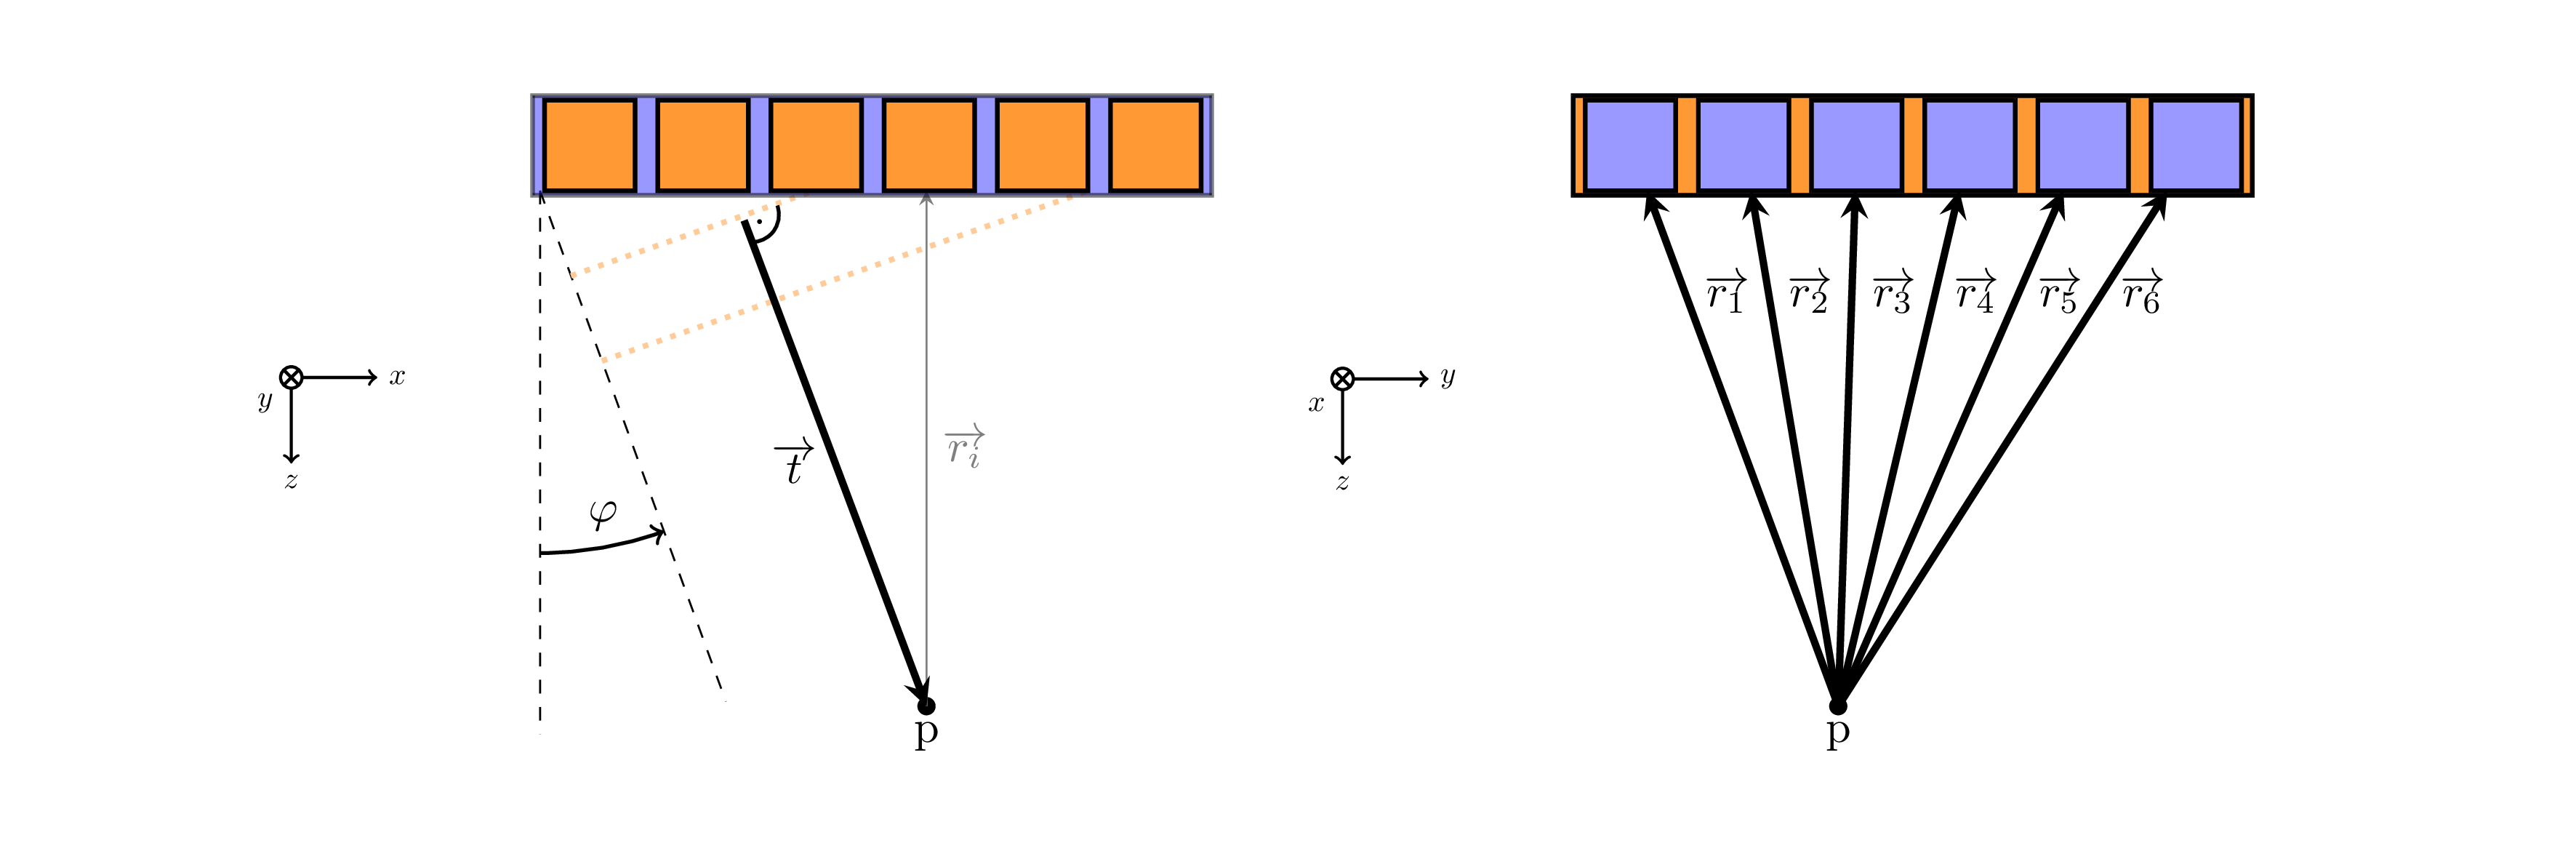


To do this, we perform the following transformations:
1. move the origin of the coordinate system to the left end of the transmit aperture,
2. rotate vector $(x, z)$ by $\pi/2$, to $(-z, x)$,
3. compute dot product between $(-z, x)$ and a unit vector in the direction of $varphi$ angle,
4. if the dot product is less than $0$, the point $(z, x)$ is in the insonified area.

(we can do analogous calculations for the right end of the aperture)

In [ ]:
plt.imshow(beamformer_cfg["tx_apodization"][-1].get().T)
plt.colorbar()

**RX apodization**

In the case of RX apodization:
- the signal from the selected probe element will be only included in calculation points $p$ located in the field of view $(-\arctan(0.5), \arctan(0.5))$ (value $0.5$ was determined experimentally),
- we apply a Gaussian window on the signal from the aperture elements.

In [ ]:
plt.imshow(beamformer_cfg["rx_apodization"][32].get().T)
plt.colorbar()

Now, let's move on to the implementation of the GPU kernel, which we will use to reconstruct B-mode volume from raw channel data using the pre-computed TX/RX delays and apodization weights. The beamformer implementation is available in the `1_delayAndSumLUT.cc` file. The below function compiles it, prepares input data, computes block and grid sizes and calls the kernel.

In [ ]:
def delay_and_sum_lut(input_array,
                      output_grid,
                      medium, device, tx_rx_sequence,
                      tx_apodization, rx_apodization,
                      tx_delays, rx_delays):
    # Initialization
    # Compile beamformer source code.
    kernel_source = pathlib.Path("1_delayAndSumLUT.cc").read_text()
    kernel_module = cp.RawModule(code=kernel_source)
    kernel_module.compile()
    kernel = kernel_module.get_function("delayAndSumLUT")
    n_tx, n_rx, n_samples = input_array.shape
    x_grid, y_grid, z_grid = output_grid
    output_array = cp.zeros((n_tx, len(y_grid), len(x_grid), len(z_grid)),
                            dtype=cp.float32)
    
    init_delay = tx_rx_sequence["init_delay"][0].item()
    fc = tx_rx_sequence["transmit_frequency"][0].item()
    fs = device["sampling_frequency"][0].item()
    
    input_array = cp.asarray(input_array).astype(cp.float32)
    n_tx, n_y_pix, n_x_pix, n_z_pix = output_array.shape
    params = (
        output_array,
        input_array,
        tx_apodization.astype(cp.uint8),
        rx_apodization.astype(cp.float32),
        tx_delays.astype(cp.float32),
        rx_delays.astype(cp.float32),
        np.float32(init_delay),
        n_tx, n_samples, n_rx,
        n_x_pix, n_y_pix, n_z_pix,
        np.float32(fs), np.float32(fc)
    )
    x_block_size = min(n_x_pix, 8)
    y_block_size = min(n_y_pix, 8)
    z_block_size = min(n_z_pix, 8)
    block_size = (
        z_block_size,
        x_block_size,
        y_block_size
    )
    grid_size = (
        (n_z_pix-1)//z_block_size+1,
        (n_x_pix-1)//x_block_size+1,
        (n_y_pix-1)//y_block_size+1
    )
    kernel(
        grid_size,
        block_size,
        params
    )
    return output_array.get()

We will use the following function to convert the beamformed data to B-mode images.

In [ ]:
def postprocess(data_xz, data_yz, tx_rx_sequence, output_grid, tgc_alpha_coeff=0, tgc_alpha_power=1, dynamic_range=(-20, 0)):
    data_yz = data_yz.transpose((0, 2, 1, 3))
    # Compound.
    hri = (np.mean(data_xz, axis=0)+np.mean(data_yz, axis=0))/2
    # TCG
    if tgc_alpha_coeff != 0:
        _, _, z_grid = output_grid
        z_grid = z_grid.get()
        print(z_grid.shape)
        fc = tx_rx_sequence["transmit_frequency"][0]
        gain = tgc_alpha_coeff*fc*1e-6*tgc_alpha_power
        gain = gain/8.686*1e2
        curve = np.exp(gain*2*z_grid).reshape(1, 1, -1)
        hri = hri*curve
    # Envelope.
    envelope = np.abs(scipy.signal.hilbert(hri))
    envelope_max = np.max(envelope)
    # B-mode.
    bmode = 20*np.log10(envelope/envelope_max)
    # Adjust dynamic range.
    vmin, vmax = dynamic_range
    bmode = np.clip(bmode, a_min=vmin, a_max=vmax)
    bmode = np.transpose(bmode, (2, 0, 1))
    return bmode

#### Testing

In this section, we test the implementation of the reconstruction algorithm on the available datasets. 

Note: data sets include raw channel data for the following two setups:
1. transmit with elements along the OX, receive with elements OY,
2. transmit with elements along the OY, receive with elements OX.

Taking advantage of the fact that the 2nd case is symmetrical to the 1st, we will use the same beamformer implementation for both setups, and simply transpose the output for the 2nd (please check the implementation of the `postprocess` function). This way, we avoid duplicating the beamformer kernel code.  

**Single point**

In [ ]:
f = h5py.File("data/ball.h5", "r")

medium = f["medium"]
device = f["device"]
tx_rx_sequence = f["tx_rx_sequence"]

x_grid = cp.arange(-4, 4, 0.1)*1e-3  # [m]
y_grid = cp.arange(-4, 4, 0.1)*1e-3  # [m]
z_grid = cp.arange(16, 24, 0.1)*1e-3  # [m]

output_grid = (
    x_grid, y_grid, z_grid
)

beamformer_cfg = prepare_beamformer(
    output_grid=output_grid,
    medium=medium,
    device=device,
    tx_rx_sequence=tx_rx_sequence
)

single_point_xy = delay_and_sum_lut(
    input_array=f["rf_xy"][:], 
    output_grid=output_grid,
    medium=medium,
    device=device,
    tx_rx_sequence=tx_rx_sequence,
    **beamformer_cfg)

single_point_yx = delay_and_sum_lut(
    input_array=f["rf_yx"][:], 
    output_grid=output_grid,
    medium=medium,
    device=device,
    tx_rx_sequence=tx_rx_sequence,
    **beamformer_cfg)

single_point = postprocess(
    single_point_xy, single_point_yx,
    tx_rx_sequence=tx_rx_sequence,
    output_grid=output_grid,
    dynamic_range=(-20, 0))

In [ ]:
view_volume_2d(single_point, x_grid.get(), y_grid.get(), z_grid.get(), figsize=(10, 3))

In [ ]:
# Uncomment the below lines to see the 3D visualization.
# camera_state = {"position": [-10.505655646769233, -25.96663433912618, -145.55767768525075], "focalPoint": [79.5, 79.5, 79.5], "viewUp": [-0.9296744298109059, 0.007449413877255744, 0.36830688398216604], "viewAngle": 30, "parallelScale": 68.41600689897065, "clippingRange": [193.20073194266212, 337.14930875040375], "windowCenter": [0, 0], "screenBottomLeft": [-0.5, -0.5, -0.5], "screenBottomRight": [0.5, -0.5, -0.5], "screenTopRight": [0.5, 0.5, -0.5], "physicalTranslation": [-79.5, -79.5, -79.5], "physicalScale": 68.41600689897065, "physicalViewUp": [0, 1, 0], "physicalViewNorth": [0, 0, -1], "mtime": 66608, "distance": 264.33915198114886}
# view_volume_3d(single_point, colormap="Cool to Warm", camera=camera_state)

**Wire phantom**

In [ ]:
f = h5py.File("data/multi_wire.h5", "r")

medium = f["medium"]
device = f["device"]
tx_rx_sequence = f["tx_rx_sequence"]

x_grid = cp.arange(-10, 10, 0.1)*1e-3  # [m]
y_grid = cp.arange(-10, 10, 0.1)*1e-3  # [m]
z_grid = cp.arange(5, 50, 0.1)*1e-3  # [m]

output_grid = (
    x_grid, y_grid, z_grid
)

beamformer_cfg = prepare_beamformer(
    output_grid=output_grid,
    medium=medium,
    device=device,
    tx_rx_sequence=tx_rx_sequence
)

wires_xy = delay_and_sum_lut(
    input_array=f["rf_xy"][:], 
    output_grid=output_grid,
    medium=medium,
    device=device,
    tx_rx_sequence=tx_rx_sequence,
    **beamformer_cfg)

wires_yx = delay_and_sum_lut(
    input_array=f["rf_yx"][:], 
    output_grid=output_grid,
    medium=medium,
    device=device,
    tx_rx_sequence=tx_rx_sequence,
    **beamformer_cfg)

wires = postprocess(
    wires_xy, wires_yx, 
    tx_rx_sequence=tx_rx_sequence, 
    output_grid=output_grid, 
    tgc_alpha_coeff=0.7, tgc_alpha_power=1.5, 
    dynamic_range=(-10, 0))

In [ ]:
view_volume_2d(wires, x_grid.get(), y_grid.get(), z_grid.get(), figsize=(10, 5))

In [ ]:
# Uncomment the below lines to see the 3D visualization.
# camera_state = {"position": [-13.625584081936577, -890.0895638036304, 367.908122256037], "focalPoint": [362.5, 161, 161], "viewUp": [-0.9429152274692622, 0.31784252364289906, -0.09943341476034367], "viewAngle": 30}
# view_volume_3d(wires, edge_gradient=0.4, colormap="Cool to Warm", camera=camera_state)

**Cyst**

In [ ]:
f = h5py.File("data/cyst.h5", "r")

medium = f["medium"]
device = f["device"]
tx_rx_sequence = f["tx_rx_sequence"]

x_grid = cp.arange(-10, 10, 0.15)*1e-3  # [m]
y_grid = cp.arange(-10, 10, 0.15)*1e-3  # [m]
z_grid = cp.arange(10, 30, 0.15)*1e-3  # [m]

output_grid = (
    x_grid, y_grid, z_grid
)

beamformer_cfg = prepare_beamformer(
    output_grid=output_grid,
    medium=medium,
    device=device,
    tx_rx_sequence=tx_rx_sequence
)

cyst_xy = delay_and_sum_lut(
    input_array=f["rf_xy"][:], 
    output_grid=output_grid,
    medium=medium,
    device=device,
    tx_rx_sequence=tx_rx_sequence,
    **beamformer_cfg)

cyst_yx = delay_and_sum_lut(
    input_array=f["rf_yx"][:], 
    output_grid=output_grid,
    medium=medium,
    device=device,
    tx_rx_sequence=tx_rx_sequence,
    **beamformer_cfg)

cyst = postprocess(
    cyst_xy, cyst_yx, 
    tx_rx_sequence=tx_rx_sequence, 
    output_grid=output_grid,
    tgc_alpha_coeff=0.7, tgc_alpha_power=1.5, 
    dynamic_range=(-17, 0))

In [ ]:
view_volume_2d(cyst, x_grid.get(), y_grid.get(), z_grid.get(), figsize=(10, 5))

In [ ]:
# Uncomment the below lines to see the 3D visualization.
# camera_state = {"position": [-195.56552833013455,-211.72156083213406,-360.49602691514167],"focalPoint": [255,169.5,169.5],"viewUp": [-0.810542332416492,0.46749694290132965,0.35279985223741744], "viewAngle": 30}
# view_volume_3d(cyst, edge_gradient=0.4, camera=camera_state)

#### Profiling

In [ ]:
%%writefile 1_delay_and_sum_lut.py

import h5py
import cupy as cp
from rca_reconstruction import (
    prepare_beamformer, 
    delay_and_sum_lut
)

f = h5py.File("data/cyst.h5", "r")

medium = f["medium"]
device = f["device"]
tx_rx_sequence = f["tx_rx_sequence"]

x_grid = cp.arange(-10, 10, 0.15)*1e-3  # [m]
y_grid = cp.arange(-10, 10, 0.15)*1e-3  # [m]
z_grid = cp.arange(10, 30, 0.15)*1e-3  # [m]

output_grid = (
    x_grid, y_grid, z_grid
)

beamformer_cfg = prepare_beamformer(
    output_grid=output_grid,
    medium=medium,
    device=device,
    tx_rx_sequence=tx_rx_sequence
)
for i in range(10):
    cyst_xy = delay_and_sum_lut(
        input_array=f["rf_xy"][:], 
        output_grid=output_grid, 
        medium=medium,
        device=device,
        tx_rx_sequence=tx_rx_sequence,
        **beamformer_cfg)

In [ ]:
! nvprof --trace gpu python 1_delay_and_sum_lut.py

## References

[Jensen2022] Jensen, Jørgen Arendt, et al. , Anatomic and Functional Imaging using Row-Column Arrays. IEEE Transactions on Ultrasonics, Ferroelectrics, and Frequency Control (2022) https://doi.org/10.1109/TUFFC.2022.3191391

[Flesch2017] Flesch, M., et al. "4D in vivo ultrafast ultrasound imaging using a row-column addressed matrix and coherently-compounded orthogonal plane waves." Physics in Medicine & Biology 62.11 (2017): 4571. https://iopscience.iop.org/article/10.1088/1361-6560/aa63d9/meta